In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import pytensor.tensor as pt
import numpyro

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#graphvizを使うためPATHを設定
import os
# Replace 'path_to_graphviz_bin' with the actual path to your Graphviz 'bin' directory.
# 仮想環境名が通常のPymc環境(/opt/conda/envs/pymc-dev/bin/)と違うため注意
graphviz_bin_path = '/opt/conda/envs/pymc-test/bin/'
# Append the Graphviz 'bin' directory to the PATH.
os.environ["PATH"] += os.pathsep + graphviz_bin_path

(array([30., 28., 29., 32., 25., 23., 17.,  5.,  7.,  4.]),
 array([0.00299458, 0.22503771, 0.44708085, 0.66912398, 0.89116711,
        1.11321025, 1.33525338, 1.55729651, 1.77933965, 2.00138278,
        2.22342591]),
 <BarContainer object of 10 artists>)

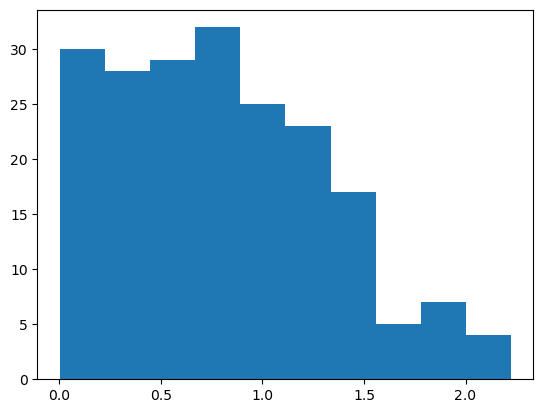

In [4]:
#標準偏差:1の半正規分布をサンプリング
temp1 = pm.HalfNormal.dist(sigma=1,shape=(200,))
a1_true = pm.draw(temp1)

plt.hist(a1_true)

In [5]:
a1_true.shape

(200,)

(array([ 2.,  5., 15., 32., 36., 40., 34., 23., 11.,  2.]),
 array([-2.98224084, -2.39088557, -1.7995303 , -1.20817503, -0.61681976,
        -0.02546449,  0.56589078,  1.15724605,  1.74860132,  2.33995659,
         2.93131186]),
 <BarContainer object of 10 artists>)

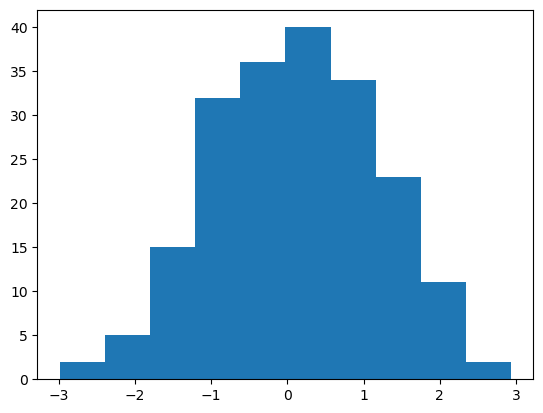

In [6]:
#標準偏差:1の正規分布をサンプリング
temp2 = pm.Normal.dist(sigma=1,shape=(200,))
a2_true = pm.draw(temp2)

plt.hist(a2_true)

(array([36., 39., 33., 31., 16., 21., 14.,  6.,  2.,  2.]),
 array([1.77044990e-03, 2.47084729e-01, 4.92399007e-01, 7.37713286e-01,
        9.83027565e-01, 1.22834184e+00, 1.47365612e+00, 1.71897040e+00,
        1.96428468e+00, 2.20959896e+00, 2.45491324e+00]),
 <BarContainer object of 10 artists>)

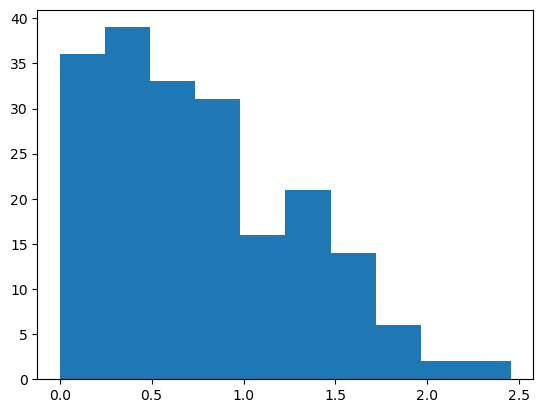

In [7]:
#標準偏差:1の半正規分布をサンプリング 誤差項
temp3 = pm.HalfNormal.dist(sigma=1,shape=(200,))
epsilon_true = pm.draw(temp3)

plt.hist(epsilon_true)

In [8]:
pd.DataFrame({'a1_true':a1_true,'a2_true':a2_true,'epsilon_true':epsilon_true})

,a1_true,a2_true,epsilon_true
0,0.672033,0.161290,0.958573
1,0.973917,-0.629554,0.309704
2,1.181705,-1.072321,1.148078
3,1.065306,-2.262399,0.531009
4,1.148487,-0.642397,1.556493
...,...,...,...
195,0.103131,-0.002987,0.937754
196,0.985013,0.245944,0.913476
197,0.375349,0.030724,0.258224
198,0.468715,1.455733,1.764526


## 考え方  
a1_trueは半正規分布からサンプルした200の値　a2_trueは正規分布からサンプルした200の値  
↑が推定したい事前分布  
次に2×200行の一様分布からサンプルした特徴量を生成する(いわゆる観測できる値)

In [9]:
# 下限0,上限1の一様分布から200個サンプル
temp3 = pm.Uniform.dist(lower=0, upper=1,shape=(200,))
temp4 = pm.Uniform.dist(lower=0, upper=1,shape=(200,))
x1 = pm.draw(temp3)
x2 = pm.draw(temp4)

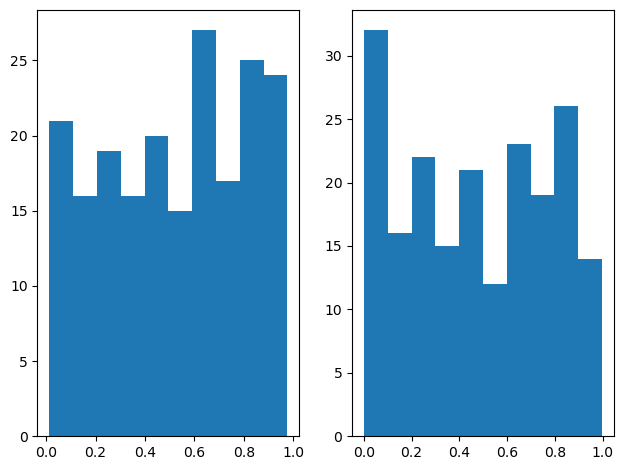

In [10]:
# 作成したx1,x2を可視化
fig ,ax = plt.subplots(1,2)
ax[0].hist(x1)
ax[1].hist(x2)
fig.tight_layout()

In [11]:
# 真の値を利用した目的変数を作成　変数複数
y = x1 *a1_true + x2 *a2_true + epsilon_true

In [12]:
y

array([ 1.490061  ,  0.42327298,  1.35098792,  1.25310006,  2.28844874,
       -0.09169085,  0.98692225,  2.98924985,  0.48741598,  0.2994885 ,
        2.00776724,  1.76494512,  0.83841013, -0.25201713,  0.97448084,
        0.89465514,  0.89838925,  1.17569311,  1.67887914,  0.11221181,
        2.58176206,  1.91172285,  2.10295069,  1.89368881,  4.06574407,
        0.53897927,  1.06899032,  0.97263439,  1.43111111,  1.57399179,
        1.40791209,  1.74239689,  1.28425709,  1.96731001,  0.58678302,
        1.76715987,  0.99493015,  0.76798984,  2.48944774,  2.96382237,
       -0.24369525,  0.52853148,  1.34529107,  2.74103529,  1.1309464 ,
        1.96681086,  2.40025805,  1.79926611,  1.58898809, -0.03786348,
        0.06593321,  0.34053775,  4.88597296,  0.7622985 ,  0.5366261 ,
        1.18619155,  1.69941692,  2.24085539,  0.70345871,  2.56758302,
        2.10059411,  1.43913775,  1.97122877,  1.68343947,  3.23046731,
        2.12133286,  0.15439473,  0.87377323,  0.95205764,  0.50

(array([ 1., 19., 39., 48., 47., 28., 13.,  2.,  2.,  1.]),
 array([-1.06636799, -0.47113389,  0.1241002 ,  0.7193343 ,  1.31456839,
         1.90980249,  2.50503658,  3.10027068,  3.69550477,  4.29073886,
         4.88597296]),
 <BarContainer object of 10 artists>)

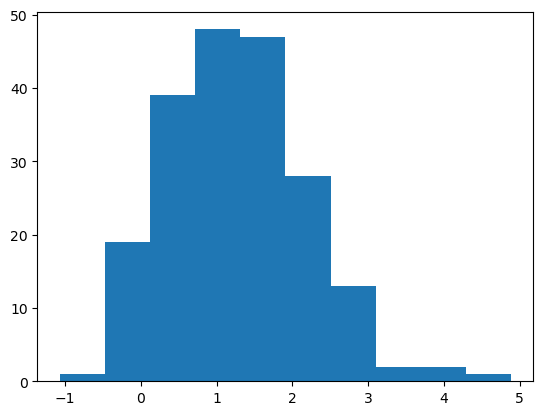

In [13]:
plt.hist(y)

In [14]:
df1 = pd.DataFrame({'x1':x1,'x2':x2, 'y':y})

In [15]:
# 観測できているデータを確認
df1

,x1,x2,y
0,0.623843,0.695925,1.490061
1,0.164961,0.074798,0.423273
2,0.270571,0.108947,1.350988
3,0.740420,0.029474,1.253100
4,0.644592,0.012997,2.288449
...,...,...,...
195,0.559578,0.404575,0.994255
196,0.675230,0.245431,1.638948
197,0.146920,0.231719,0.320490
198,0.606153,0.688900,3.051494


## モデル1を作成  
x1には半正規分布の事前分布を設定  
x２には正規分布の事前分布を設定  
y(尤度)はStudentT分布にする

In [16]:
df_x1=df1['x1']
df_x2=df1['x2']
df_y =df1['y']

In [55]:
model1 = pm.Model()

In [56]:
with model1:
    #観測データを定義
    model1.add_coord('data',df_x1.index, mutable=True)
    model1.add_coord('var',df1.columns, mutable=True)
    x1_data= pm.Data("x1_data", df_x1, dims=('data'), mutable=True)
    x2_data= pm.Data("x2_data", df_x2, dims=('data'), mutable=True)
    y_data = pm.Data("y_data", df_y, dims=('data'), mutable=True)

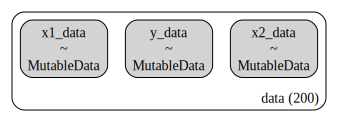

In [57]:
pm.model_to_graphviz(model1)

In [58]:
with model1:
    #事前分布を定義
    
    #切片を標準偏差100の正規分布で定義
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    #x1の傾きを半正規分布で定義
    a1 = pm.HalfNormal("a1", sigma=1)
    #x2の傾きを正規分布で定義
    a2= pm.Normal("a2",mu=0, sigma=1)
    
    #誤差を半正規分布で定義
    epsilon = pm.HalfNormal("epsilon", sigma=1)

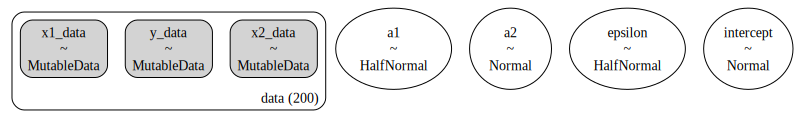

In [59]:
pm.model_to_graphviz(model1)

In [60]:
with model1:
    #観測データ(正規分布を仮定)の平均を計算　重回帰の計算結果が平均となる
    mu = pm.Deterministic("mu", intercept + pt.dot(x1_data, a1) + pt.dot(x2_data,a2), dims=('data',))
    #StudentT分布のパラメータの事前分布を定義
    nu = pm.Gamma("nu",alpha=2,beta=0.1,dims=('data',))
    
    #観測データ(尤度)(正規分布を仮定)を定義
    obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=epsilon, observed=y_data, dims=('data',)) 

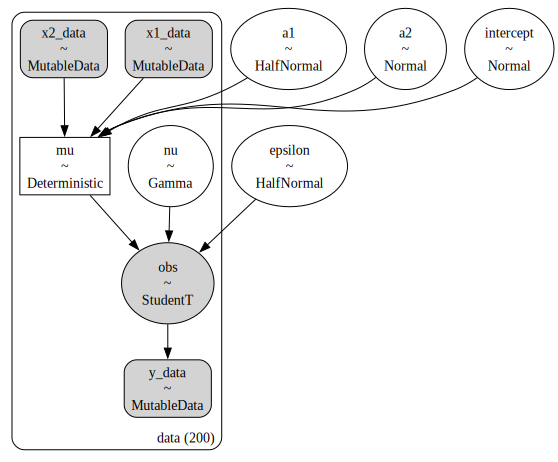

In [61]:
pm.model_to_graphviz(model1)

### 事前分布の妥当性を確認するために事前分布を用いてサンプリング

In [24]:
with model1:
    idata = pm.sample_prior_predictive(samples=200, random_seed=42)

Sampling: [a1, a2, epsilon, intercept, nu, obs]


/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


(0.0, 1.0)

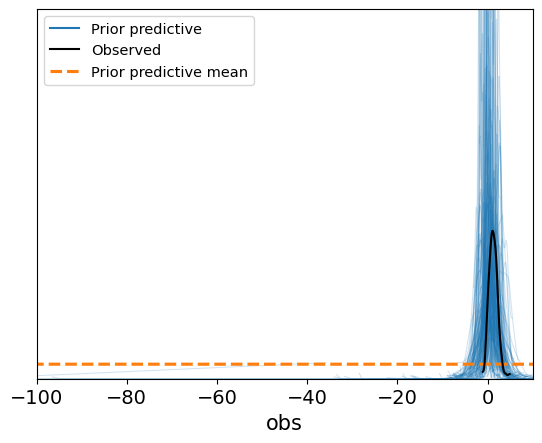

In [25]:
az.plot_ppc(idata, num_pp_samples=200, group="prior")
plt.xlim(-100, 10)
plt.ylim(0,1)

In [31]:
model2 = pm.Model()

In [32]:
with model2:
    #観測データを定義
    model1.add_coord('data',df_x1.index, mutable=True)
    model1.add_coord('var',df1.columns, mutable=True)
    x1_data= pm.Data("x1_data", df_x1, dims=('data'), mutable=True)
    x2_data= pm.Data("x2_data", df_x2, dims=('data'), mutable=True)
    y_data = pm.Data("y_data", df_y, dims=('data'), mutable=True)

In [33]:
with model2:
    #事前分布を定義
    
    #切片を標準偏差100の正規分布で定義
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    #x1の傾きを半正規分布で定義
    a1 = pm.HalfNormal("a1", sigma=100)
    #x2の傾きを正規分布で定義
    a2= pm.Normal("a2",mu=0, sigma=100)
    
    #誤差を半正規分布で定義
    epsilon = pm.HalfNormal("epsilon", sigma=100)

In [34]:
with model2:
    #観測データ(正規分布を仮定)の平均を計算　重回帰の計算結果が平均となる
    mu = pm.Deterministic("mu", intercept + pt.dot(x1_data, a1) + pt.dot(x2_data,a2), dims=('data',))
    
    #観測データ(尤度)(正規分布を仮定)を定義
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y_data, dims=('data',)) 

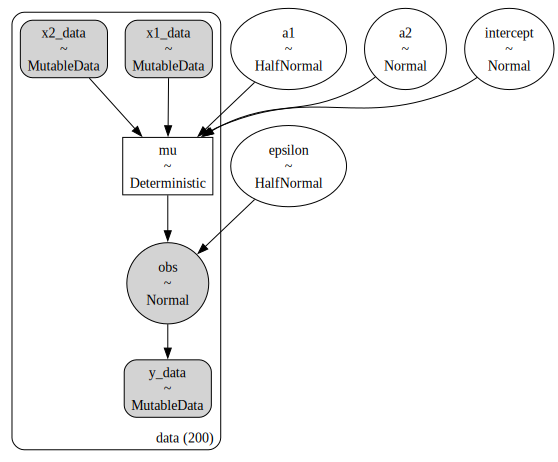

In [35]:
# モデルの構成は変わらない
pm.model_to_graphviz(model2)

##### 事前分布と観測データが重なっておりある程度妥当な事前分布と判断できる

#### MCMC実行

In [62]:
#モデル比較のためidata_kwargs={"log_likelihood": True}で対数尤度もサンプルする
with model1:
    idata1 = pm.sample(4000,target_accept=0.95,nuts_sampler="blackjax",random_seed=42,idata_kwargs={"log_likelihood": True})

Compiling...
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pymc/sampling/jax.py:459: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:01.297640
Sampling...
Sampling time = 0:00:09.601997
Transforming variables...
Transformation time = 0:00:00.137082
Computing Log Likelihood...
Log Likelihood time = 0:00:00.457091


In [63]:
summary1 = az.summary(idata1,var_names=['a1','a2','epsilon'])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.805,0.209,0.393,1.182,0.001,0.001,22301.0,9747.0,1.0
a2,-0.019,0.206,-0.407,0.366,0.001,0.002,28802.0,12066.0,1.0
epsilon,0.821,0.048,0.731,0.910,0.000,0.000,31369.0,12634.0,1.0


In [64]:
#モデル比較のためidata_kwargs={"log_likelihood": True}で対数尤度もサンプルする
with model2:
    idata2 = pm.sample(4000,target_accept=0.95,nuts_sampler="blackjax",random_seed=42,idata_kwargs={"log_likelihood": True})

Compiling...
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pymc/sampling/jax.py:459: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:00.730789
Sampling...
Sampling time = 0:00:03.858595
Transforming variables...
Transformation time = 0:00:00.092284
Computing Log Likelihood...
Log Likelihood time = 0:00:00.139354


In [65]:
summary2 = az.summary(idata2,var_names=['a1','a2','epsilon'])
display(summary2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.857,0.226,0.436,1.285,0.003,0.002,6660.0,4363.0,1.0
a2,0.045,0.212,-0.360,0.432,0.002,0.002,9704.0,9708.0,1.0
epsilon,0.904,0.046,0.822,0.992,0.000,0.000,11694.0,9690.0,1.0


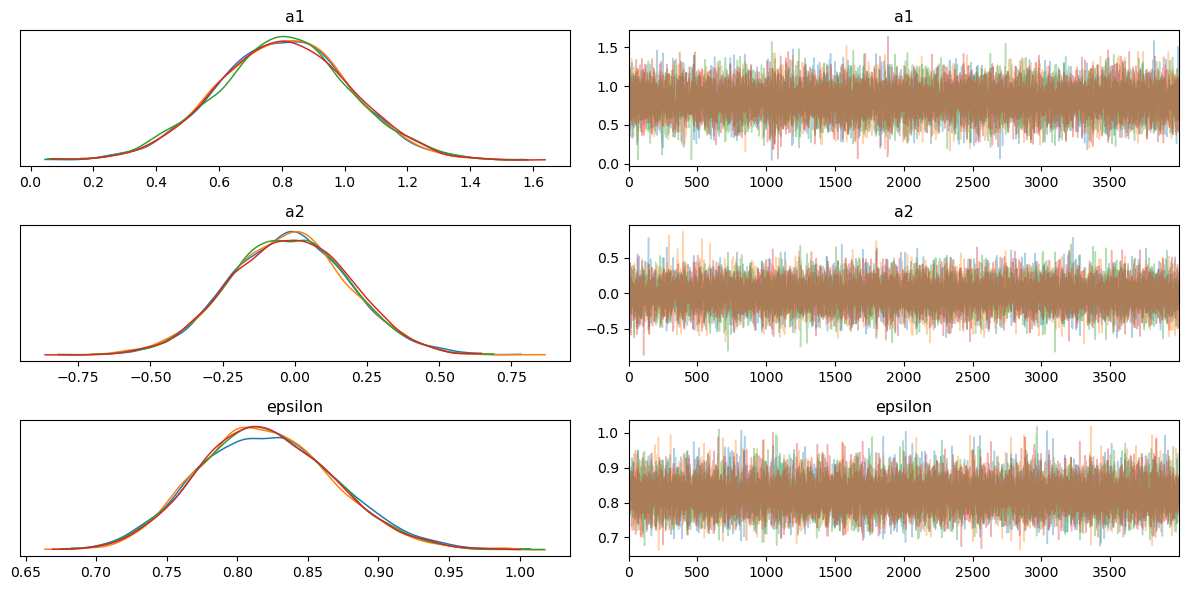

In [66]:
#model1のトレース結果
az.plot_trace(idata1, compact=False, var_names=['a1','a2','epsilon'])
plt.tight_layout()

array([<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a2'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

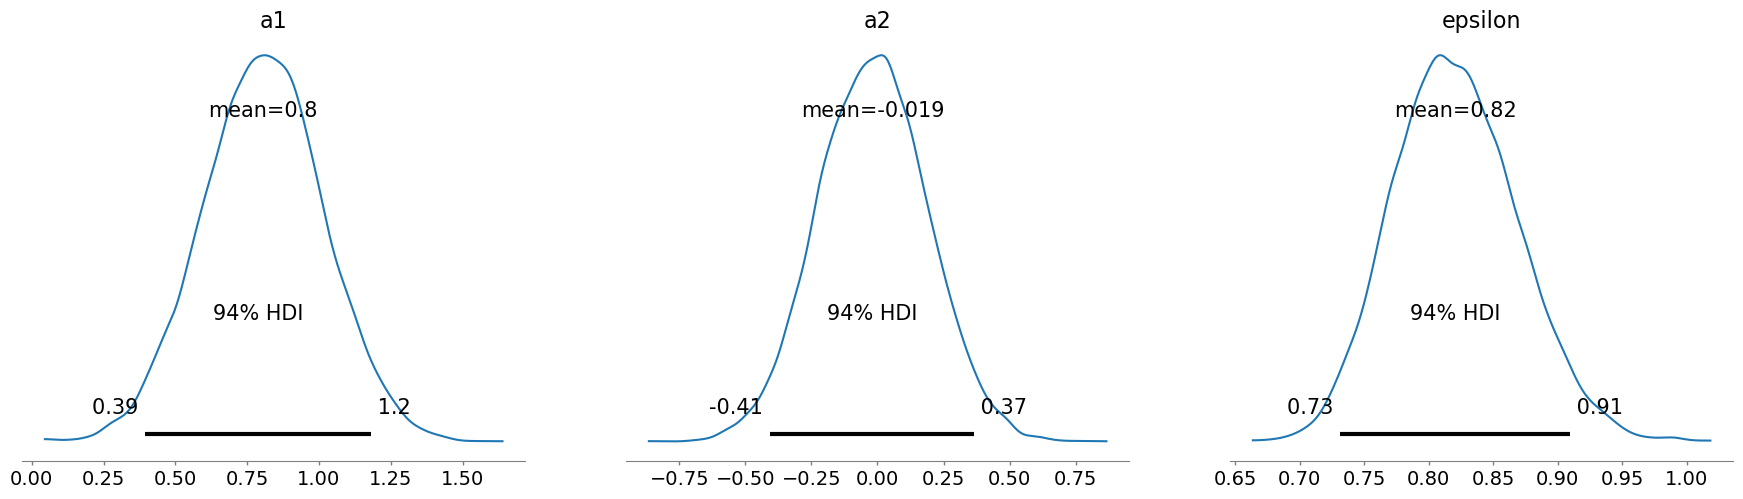

In [68]:
#model1のサンプラーのトレース結果
az.plot_posterior(idata1, var_names=['a1','a2','epsilon'])

##### Energyプロットを確認  
理想的なプロットとしてはMarginal EnergyとEnergy Transitionの分布が一致しているこ  
一致していればHMCやNUTSは目的としている分布をよくサンプリングできていることを意味する  
Energy Transition分布の方がMarginal Energyの分布より狭い場合、HMCやNUTSは目的としている領域の一部しかサンプリングできていないことを意味する

<Axes: >

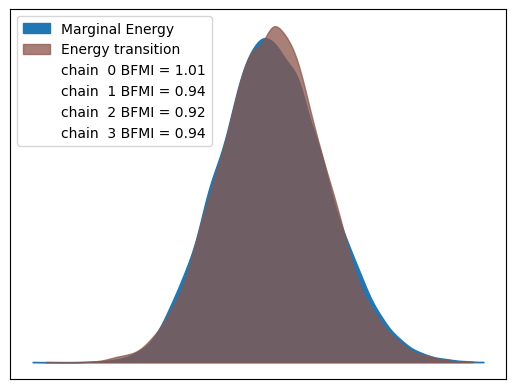

In [40]:
az.plot_energy(idata1)

## MCMCの結果考察  
R_hatが1.0、グラフも定常状態になっているため収束出来ていると判断  
Marginal EnergyとEnergy Transitionの分布もどちらのModelもある程度一致しているためサンプリングもある程度上手くできている

## 真の値とMCMCの結果の比較

In [69]:
a1_true.mean()

0.805380500071363

In [70]:
a2_true.mean()

0.09951933057354076

In [71]:
#model1のa1の平均値
idata1['posterior']['a1'].values.mean()

0.804519872711249

In [72]:
#model1のa2の平均値
idata1['posterior']['a2'].values.mean()

-0.018955924448308452

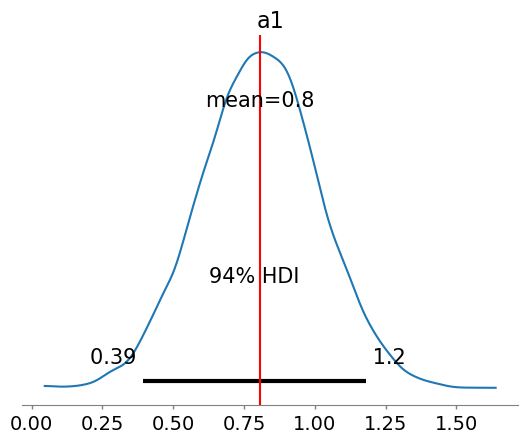

In [73]:
## model1のa1結果確認
az.plot_posterior(idata1, var_names=['a1'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a1_true.mean(),color='red')

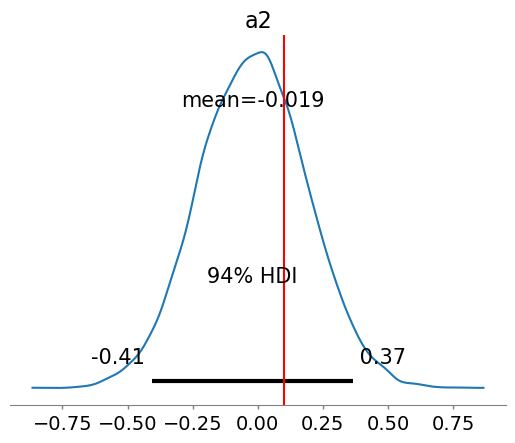

In [74]:
## model1のa2結果確認
az.plot_posterior(idata1, var_names=['a2'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a2_true.mean(),color='red')

In [75]:
df_comp_loo = az.compare({"model1": idata1, "model2": idata2})
df_comp_loo

/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1,0,-264.504452,6.252301,0.000000,0.530496,10.963712,0.000000,False,log
model2,1,-265.154502,4.216596,0.650049,0.469504,11.603198,2.444313,False,log


/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

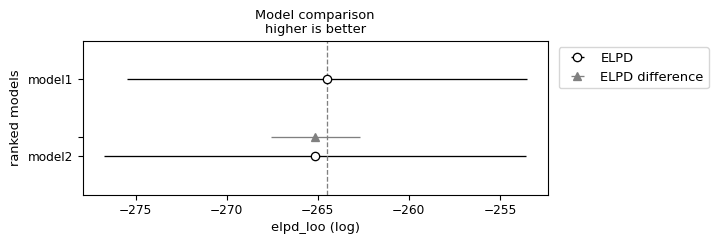

In [76]:
az.plot_compare(df_comp_loo, insample_dev=False)